In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import sys

from Bio import SeqIO
from Bio import pairwise2
from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## variables

In [4]:
tss_map_f = "../../../data/01__design/01__mpra_list/mpra_tss.with_ids.RECLASSIFIED.txt"

In [5]:
index_f = "../../../data/01__design/02__index/TWIST_pool4_v8_final.with_element_id.txt.gz"

In [6]:
data_f = "../../../data/02__mpra/03__results/all_processed_results.txt"

## 1. import data

In [7]:
tss_map = pd.read_table(tss_map_f, sep="\t")
tss_map.head()

,hg19_id,mm9_id,cage_id_hg19,cage_id_mm9,name_peak_hg19,name_peak_mm9,biotype_hg19,biotype_mm9,minimal_biotype_hg19,minimal_biotype_mm9,...,end_tss_mm9,strand_tss_mm9,avg_exp_hg19,avg_exp_mm9,stem_exp_hg19,stem_exp_mm9,max_cage_hg19,max_cage_mm9,orig_species,har
0,h.0,m.0,"chr1:2984976..2984989,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.1,0.43,0.027777800000000002,0.0175,367.0,2286.0,human,False
1,h.1,m.0,"chr1:2984997..2985037,-","chr4:154011655..154011673,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011664,+,0.29,0.43,0.0311111,0.0175,367.0,2286.0,human,False
2,h.2,m.1,"chr1:2985420..2985438,-","chr4:154011250..154011257,+",ENSG00000177133.6,ENSMUSG00000085069.2,divergent,divergent,lncRNA,lncRNA,...,154011253,+,2.54,0.85,0.07111110000000001,0.0,6966.0,1361.0,human,False
3,h.3,m.2,"chr1:8086546..8086571,+","chr4:150229039..150229050,-",ENSG00000238290.1,ENSMUSG00000078492.3,divergent,antisense,lncRNA,lncRNA,...,150229045,-,0.3,0.14,0.10444400000000001,0.0,960.0,123.0,human,False
4,h.4,m.3,"chr1:26498321..26498327,-","chr4:133799669..133799683,+",ENSG00000236782.1,ENSMUSG00000086322.7,antisense,protein_coding,other,mRNA,...,133799678,+,0.19,0.25,0.03,0.0,753.0,770.0,human,False


In [8]:
index = pd.read_table(index_f)
index.head()

,element,tile_type,tile_id,name,parse_details,chrom,start,end,strand,actual_start,...,RE_2,RE_3,unique_name,snp,dupe_info,barcode,oligo,oligo_len,elem_id,element_id
0,AGAAATGAAGTCTACTTCCAGTTAATGTTCTTTCTGGTATGTCTTT...,WILDTYPE,1.2.0.0.1,HUMAN_XIST_PROMOTER,"HUMAN_XIST_PROMOTER;WT,SINGLEMUT",chrX,73070662,73072847,-,73072613,...,1,0.0,"HUMAN_XIST_PROMOTER:73072613-73072757,-",none,1.2.0.0,CTACGGCACCC,ACTGGCCGCTTCACTGAGAAATGAAGTCTACTTCCAGTTAATGTTC...,200,"HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0","HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0"
1,AGAAATGAAGTCTACTTCCAGTTAATGTTCTTTCTGGTATGTCTTT...,WILDTYPE,1.2.0.0.2,HUMAN_XIST_PROMOTER,"HUMAN_XIST_PROMOTER;WT,SINGLEMUT",chrX,73070662,73072847,-,73072613,...,1,0.0,"HUMAN_XIST_PROMOTER:73072613-73072757,-",none,1.2.0.0,GAGACGAATCA,ACTGGCCGCTTCACTGAGAAATGAAGTCTACTTCCAGTTAATGTTC...,200,"HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0","HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0"
2,AGAAATGAAGTCTACTTCCAGTTAATGTTCTTTCTGGTATGTCTTT...,WILDTYPE,1.2.0.0.3,HUMAN_XIST_PROMOTER,"HUMAN_XIST_PROMOTER;WT,SINGLEMUT",chrX,73070662,73072847,-,73072613,...,1,0.0,"HUMAN_XIST_PROMOTER:73072613-73072757,-",none,1.2.0.0,CTAAGCGTACG,ACTGGCCGCTTCACTGAGAAATGAAGTCTACTTCCAGTTAATGTTC...,200,"HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0","HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0"
3,AGAAATGAAGTCTACTTCCAGTTAATGTTCTTTCTGGTATGTCTTT...,WILDTYPE,1.2.0.0.4,HUMAN_XIST_PROMOTER,"HUMAN_XIST_PROMOTER;WT,SINGLEMUT",chrX,73070662,73072847,-,73072613,...,1,0.0,"HUMAN_XIST_PROMOTER:73072613-73072757,-",none,1.2.0.0,AACCGTCAATC,ACTGGCCGCTTCACTGAGAAATGAAGTCTACTTCCAGTTAATGTTC...,200,"HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0","HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0"
4,AGAAATGAAGTCTACTTCCAGTTAATGTTCTTTCTGGTATGTCTTT...,WILDTYPE,1.2.0.0.5,HUMAN_XIST_PROMOTER,"HUMAN_XIST_PROMOTER;WT,SINGLEMUT",chrX,73070662,73072847,-,73072613,...,1,0.0,"HUMAN_XIST_PROMOTER:73072613-73072757,-",none,1.2.0.0,GGATTAATCAC,ACTGGCCGCTTCACTGAGAAATGAAGTCTACTTCCAGTTAATGTTC...,200,"HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0","HUMAN_XIST_PROMOTER:73072613-73072757,-;1.2.0.0"


In [9]:
len(index)

239653

In [10]:
data = pd.read_table(data_f)
data.head()

,hg19_id,chr_tss_hg19,start_tss_hg19,biotype_hg19,cage_id_hg19,name_peak_hg19,minimal_biotype_hg19,stem_exp_hg19,mm9_id,chr_tss_mm9,...,trans_mouse_status,trans_human_status_det,trans_mouse_status_det,trans_status_one,trans_status_det_one,logFC_trans_one,logFC_int,fdr_int,cis_trans_int_status,cis_trans_int_status_det
0,h.2,chr1,2985430.0,divergent,"chr1:2985420..2985438,-",ENSG00000177133.6,lncRNA,0.07111110000000001,m.1,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.325920,-0.050780,0.991115,no cis/trans int. effect,no cis/trans int. effect
1,h.3,chr1,8086552.0,divergent,"chr1:8086546..8086571,+",ENSG00000238290.1,lncRNA,0.10444400000000001,m.2,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.533476,-0.405629,0.908445,no cis/trans int. effect,no cis/trans int. effect
2,h.4,chr1,26498322.0,antisense,"chr1:26498321..26498327,-",ENSG00000236782.1,other,0.03,m.3,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,0.270223,-0.210732,0.960813,no cis/trans int. effect,no cis/trans int. effect
3,h.5,chr1,65533428.0,intergenic,"chr1:65533390..65533443,-",ENSG00000231485.1,lncRNA,0.841111,m.4,chr4,...,no trans effect,trans effect\n(higher in mouse),no trans effect,significant trans effect,trans effect\n(higher in mouse),0.449668,-0.740913,0.152051,no cis/trans int. effect,no cis/trans int. effect
4,h.6,chr1,65533462.0,intergenic,"chr1:65533457..65533465,-",ENSG00000231485.1,lncRNA,0.116667,m.4,chr4,...,no trans effect,no trans effect,no trans effect,no trans effect,no trans effect,-0.270646,-0.528464,0.379849,no cis/trans int. effect,no cis/trans int. effect


## 2. make bed file for every non-conserved TSS
bed file with TSS region and lifted-over non-TSS region

In [11]:
dedupe = tss_map.drop("orig_species", axis=1).drop_duplicates()
dedupe = dedupe[["chr_tss_hg19", "start_tss_hg19", "end_tss_hg19", "strand_tss_hg19", "cage_id_hg19", "hg19_id",
                 "chr_tss_mm9", "start_tss_mm9", "end_tss_mm9", "strand_tss_mm9", "cage_id_mm9", "mm9_id",
                 "minimal_biotype_hg19", "minimal_biotype_mm9"]].drop_duplicates()
len(dedupe)

3767

In [12]:
## join w/ tile info
tiles = data[["hg19_id", "mm9_id", "tss_tile_num"]].drop_duplicates()
dedupe = dedupe.merge(tiles, on=["hg19_id", "mm9_id"])
len(dedupe)

2934

In [13]:
non_cons = dedupe[(dedupe["minimal_biotype_hg19"] == "no CAGE activity") | 
                  (dedupe["minimal_biotype_mm9"] == "no CAGE activity")]
print(len(non_cons))
non_cons.head()

784


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,hg19_id,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,cage_id_mm9,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,tss_tile_num
640,chr1,20512044,20512045,+,"chr1:20512041..20512054,+",h.881,chr4,138281608,138281609,-,no cage activity,m.765,mRNA,no CAGE activity,tile1
660,chr10,81838814,81838815,+,"chr10:81838798..81838845,+",h.909,chr14,26746658,26746659,-,no cage activity,m.793,mRNA,no CAGE activity,tile1
667,chr11,118401131,118401132,+,"chr11:118401126..118401137,+",h.917,chr9,44608008,44608009,-,no cage activity,m.801,mRNA,no CAGE activity,tile2
676,chr12,130646537,130646538,+,"chr12:130646534..130646542,+",h.931,chr5,129106383,129106384,+,no cage activity,m.815,mRNA,no CAGE activity,tile1
678,chr13,95363875,95363876,-,"chr13:95363870..95363882,-",h.935,chr14,118634429,118634430,-,no cage activity,m.818,mRNA,no CAGE activity,tile2


In [14]:
def get_tile_start_coord(row, suffix):
    if row["tss_tile_num"] == "tile1":
        if row["strand_tss_%s" % suffix] == "+":
            tile_start = row["start_tss_%s" % suffix] - 114
        else:
            tile_start = row["start_tss_%s" % suffix] - 30
    else:
        if row["strand_tss_%s" % suffix] == "+":
            tile_start = row["end_tss_%s" % suffix] - 228
        else:
            tile_start = row["end_tss_%s" % suffix] + 84
    return tile_start

def get_tile_end_coord(row, suffix):
    if row["tss_tile_num"] == "tile1":
        if row["strand_tss_%s" % suffix] == "+":
            tile_end = row["start_tss_%s" % suffix] + 30
        else:
            tile_end = row["start_tss_%s" % suffix] + 114
    else:
        if row["strand_tss_%s" % suffix] == "+":
            tile_end = row["end_tss_%s" % suffix] - 84
        else:
            tile_end = row["end_tss_%s" % suffix] + 228
    return tile_end

In [15]:
non_cons["start_tile_hg19"] = non_cons.apply(get_tile_start_coord, suffix="hg19", axis=1)
non_cons["end_tile_hg19"] = non_cons.apply(get_tile_end_coord, suffix="hg19", axis=1)
non_cons["start_tile_mm9"] = non_cons.apply(get_tile_start_coord, suffix="mm9", axis=1)
non_cons["end_tile_mm9"] = non_cons.apply(get_tile_end_coord, suffix="mm9", axis=1)
non_cons.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,hg19_id,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,cage_id_mm9,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,tss_tile_num,start_tile_hg19,end_tile_hg19,start_tile_mm9,end_tile_mm9
640,chr1,20512044,20512045,+,"chr1:20512041..20512054,+",h.881,chr4,138281608,138281609,-,no cage activity,m.765,mRNA,no CAGE activity,tile1,20511930,20512074,138281578,138281722
660,chr10,81838814,81838815,+,"chr10:81838798..81838845,+",h.909,chr14,26746658,26746659,-,no cage activity,m.793,mRNA,no CAGE activity,tile1,81838700,81838844,26746628,26746772
667,chr11,118401131,118401132,+,"chr11:118401126..118401137,+",h.917,chr9,44608008,44608009,-,no cage activity,m.801,mRNA,no CAGE activity,tile2,118400904,118401048,44608093,44608237
676,chr12,130646537,130646538,+,"chr12:130646534..130646542,+",h.931,chr5,129106383,129106384,+,no cage activity,m.815,mRNA,no CAGE activity,tile1,130646423,130646567,129106269,129106413
678,chr13,95363875,95363876,-,"chr13:95363870..95363882,-",h.935,chr14,118634429,118634430,-,no cage activity,m.818,mRNA,no CAGE activity,tile2,95363960,95364104,118634514,118634658


In [16]:
non_cons_hu = non_cons[non_cons["minimal_biotype_hg19"] == "no CAGE activity"]
len(non_cons_hu)
non_cons_hu.sample(5)

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,hg19_id,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,cage_id_mm9,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,tss_tile_num,start_tile_hg19,end_tile_hg19,start_tile_mm9,end_tile_mm9
2414,chr12,115123194,115123195,-,no cage activity,h.3025,chr5,120119891,120119892,+,"chr5:120119885..120119925,+",m.2837,no CAGE activity,mRNA,tile1,115123164,115123308,120119777,120119921
2762,chr2,42274092,42274093,-,no cage activity,h.3447,chr17,83613664,83613665,-,chr17:83613487-83613779,m.3257,no CAGE activity,eRNA,tile1,42274062,42274206,83613634,83613778
2490,chr2,62693801,62693802,+,no cage activity,h.3123,chr11,22510341,22510342,-,"chr11:22510334..22510347,-",m.2934,no CAGE activity,lncRNA,tile1,62693687,62693831,22510311,22510455
2201,chr9,132817021,132817022,-,no cage activity,h.2741,chr2,31008688,31008689,-,"chr2:31008686..31008692,-",m.2553,no CAGE activity,lncRNA,tile1,132816991,132817135,31008658,31008802
2079,chr12,123350326,123350327,+,no cage activity,h.2586,chr5,124455008,124455009,+,"chr5:124454997..124455017,+",m.2398,no CAGE activity,other,tile1,123350212,123350356,124454894,124455038


In [17]:
non_cons_hu_bed = non_cons_hu[["chr_tss_hg19", "start_tile_hg19", "end_tile_hg19", "hg19_id", 
                               "start_tss_hg19", "strand_tss_hg19"]]
non_cons_hu_bed = non_cons_hu_bed.sort_values(by=["chr_tss_hg19", "start_tile_hg19"])
non_cons_hu_bed.head()

,chr_tss_hg19,start_tile_hg19,end_tile_hg19,hg19_id,start_tss_hg19,strand_tss_hg19
2795,chr1,10930873,10931017,h.3481,10930987,+
2887,chr1,10930923,10931067,h.3581,10930953,-
2242,chr1,25291554,25291698,h.2793,25291668,+
2886,chr1,25720129,25720273,h.3579,25720159,-
2793,chr1,25720174,25720318,h.3479,25720288,+


In [18]:
non_cons_mo = non_cons[non_cons["minimal_biotype_mm9"] == "no CAGE activity"]
len(non_cons_mo)

447

In [19]:
non_cons_mo_bed = non_cons_mo[["chr_tss_mm9", "start_tile_mm9", "end_tile_mm9", "mm9_id", 
                               "start_tss_mm9", "strand_tss_mm9"]]
non_cons_mo_bed = non_cons_mo_bed.sort_values(by=["chr_tss_mm9", "start_tile_mm9"])
non_cons_mo_bed.head()

,chr_tss_mm9,start_tile_mm9,end_tile_mm9,mm9_id,start_tss_mm9,strand_tss_mm9
1349,chr1,12981887,12982031,m.1555,12982001,+
1982,chr1,19200671,19200815,m.2367,19200785,+
1893,chr1,19200746,19200890,m.2267,19200776,-
1894,chr1,21087415,21087559,m.2268,21087445,-
1983,chr1,21087510,21087654,m.2368,21087624,+


In [20]:
# write files to perform intersections
non_cons_hu_bed.to_csv("non_cons_hu.bed", sep="\t", index=False, header=False)
non_cons_mo_bed.to_csv("non_cons_mo.bed", sep="\t", index=False, header=False)

## 3. find closest TSS to every non-conserved region

In [21]:
# ran this outside of the notebook:
# sort -k1,1 -k2,2n non_cons_mo.bed | bedtools closest -s -d -a - -b ../../../data/01__design/00__genome_list/mm9.cage_peak_phase1and2combined_coord.TSS.sorted.bed > non_cons_mo.closest_TSS.bed
# sort -k1,1 -k2,2n non_cons_hu.bed | bedtools closest -s -d -a - -b ../../../data/01__design/00__genome_list/hg19.cage_peak_phase1and2combined_coord.TSS.sorted.bed > non_cons_hu.closest_TSS.bed

In [22]:
non_cons_hu_closest = pd.read_table("non_cons_hu.closest_TSS.bed", header=None)
non_cons_hu_closest.columns = ["chr_tss_hg19", "start_tile_hg19", "end_tile_hg19", "hg19_id", "start_tss_hg19",
                               "strand_tss_hg19", "chr_closest_hg19", "start_closest_hg19", "end_closest_hg19",
                               "cage_id_closest_hg19", "score_closest_hg19", "strand_closest_hg19", 
                               "distance_closest"]
non_cons_hu_closest.head()

,chr_tss_hg19,start_tile_hg19,end_tile_hg19,hg19_id,start_tss_hg19,strand_tss_hg19,chr_closest_hg19,start_closest_hg19,end_closest_hg19,cage_id_closest_hg19,score_closest_hg19,strand_closest_hg19,distance_closest
0,chr1,10930873,10931017,h.3481,10930987,+,chr1,10875491,10875492,"chr1:10875488..10875494,+",157,+,55382
1,chr1,10930923,10931067,h.3581,10930953,-,chr1,10928118,10928119,"chr1:10928103..10928127,-",99,-,2805
2,chr1,25291554,25291698,h.2793,25291668,+,chr1,25281915,25281916,"chr1:25281902..25281921,+",1145,+,9639
3,chr1,25720129,25720273,h.3579,25720159,-,chr1,25747425,25747426,"chr1:25747423..25747428,-",104,-,27153
4,chr1,25720174,25720318,h.3479,25720288,+,chr1,25687251,25687252,"chr1:25687245..25687260,+",775,+,32923


In [23]:
non_cons_mo_closest = pd.read_table("non_cons_mo.closest_TSS.bed", header=None)
non_cons_mo_closest.columns = ["chr_tss_mm9", "start_tile_mm9", "end_tile_mm9", "mm9_id", "start_tss_mm9",
                               "strand_tss_mm9", "chr_closest_mm9", "start_closest_mm9", "end_closest_mm9",
                               "cage_id_closest_mm9", "score_closest_mm9", "strand_closest_mm9", 
                               "distance_closest"]
non_cons_mo_closest.head()

,chr_tss_mm9,start_tile_mm9,end_tile_mm9,mm9_id,start_tss_mm9,strand_tss_mm9,chr_closest_mm9,start_closest_mm9,end_closest_mm9,cage_id_closest_mm9,score_closest_mm9,strand_closest_mm9,distance_closest
0,chr1,12981887,12982031,m.1555,12982001,+,chr1,12980495,12980496,"chr1:12980493..12980507,+",284,+,1392
1,chr1,19200671,19200815,m.2367,19200785,+,chr1,19202185,19202186,"chr1:19202185..19202187,+",1197,+,1371
2,chr1,19200746,19200890,m.2267,19200776,-,chr1,19327620,19327621,"chr1:19327618..19327622,-",19,-,126731
3,chr1,21087415,21087559,m.2268,21087445,-,chr1,21069305,21069306,"chr1:21069243..21069324,-",31187,-,18110
4,chr1,21087510,21087654,m.2368,21087624,+,chr1,21208679,21208680,"chr1:21208656..21208698,+",156,+,121026


## 4. create bed file w/ human and mouse regions to make fasta

In [24]:
hu_closest = non_cons_hu_closest[["chr_tss_hg19", "start_closest_hg19", "end_closest_hg19", "hg19_id", 
                                  "distance_closest", "strand_tss_hg19"]]
hu_closest.columns = ["chr_tss_hg19", "start_tss_hg19", "end_tss_hg19", "hg19_id", "dist", "strand_tss_hg19"]
hu_closest["tss_tile_num"] = "tile1"
hu_closest.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,hg19_id,dist,strand_tss_hg19,tss_tile_num
0,chr1,10875491,10875492,h.3481,55382,+,tile1
1,chr1,10928118,10928119,h.3581,2805,-,tile1
2,chr1,25281915,25281916,h.2793,9639,+,tile1
3,chr1,25747425,25747426,h.3579,27153,-,tile1
4,chr1,25687251,25687252,h.3479,32923,+,tile1


In [25]:
hu_closest["start_tile_hg19"] = hu_closest.apply(get_tile_start_coord, suffix="hg19", axis=1)
hu_closest["end_tile_hg19"] = hu_closest.apply(get_tile_end_coord, suffix="hg19", axis=1)
hu_closest_bed = hu_closest[["chr_tss_hg19", "start_tile_hg19", "end_tile_hg19", "hg19_id", 
                             "dist", "strand_tss_hg19"]]
hu_closest_bed.head()

,chr_tss_hg19,start_tile_hg19,end_tile_hg19,hg19_id,dist,strand_tss_hg19
0,chr1,10875377,10875521,h.3481,55382,+
1,chr1,10928088,10928232,h.3581,2805,-
2,chr1,25281801,25281945,h.2793,9639,+
3,chr1,25747395,25747539,h.3579,27153,-
4,chr1,25687137,25687281,h.3479,32923,+


In [26]:
mo_closest = non_cons_mo_closest[["chr_tss_mm9", "start_closest_mm9", "end_closest_mm9", "mm9_id", 
                                  "distance_closest", "strand_tss_mm9"]]
mo_closest.columns = ["chr_tss_mm9", "start_tss_mm9", "end_tss_mm9", "mm9_id", "dist", "strand_tss_mm9"]
mo_closest["tss_tile_num"] = "tile1"
mo_closest.head()

,chr_tss_mm9,start_tss_mm9,end_tss_mm9,mm9_id,dist,strand_tss_mm9,tss_tile_num
0,chr1,12980495,12980496,m.1555,1392,+,tile1
1,chr1,19202185,19202186,m.2367,1371,+,tile1
2,chr1,19327620,19327621,m.2267,126731,-,tile1
3,chr1,21069305,21069306,m.2268,18110,-,tile1
4,chr1,21208679,21208680,m.2368,121026,+,tile1


In [27]:
mo_closest["start_tile_mm9"] = mo_closest.apply(get_tile_start_coord, suffix="mm9", axis=1)
mo_closest["end_tile_mm9"] = mo_closest.apply(get_tile_end_coord, suffix="mm9", axis=1)
mo_closest_bed = mo_closest[["chr_tss_mm9", "start_tile_mm9", "end_tile_mm9", "mm9_id", 
                             "dist", "strand_tss_mm9"]]
mo_closest_bed.head()

,chr_tss_mm9,start_tile_mm9,end_tile_mm9,mm9_id,dist,strand_tss_mm9
0,chr1,12980381,12980525,m.1555,1392,+
1,chr1,19202071,19202215,m.2367,1371,+
2,chr1,19327590,19327734,m.2267,126731,-
3,chr1,21069275,21069419,m.2268,18110,-
4,chr1,21208565,21208709,m.2368,121026,+


### append orig tiles, non-cons tiles, and closest tiles

In [28]:
non_cons_hu_bed["name"] = non_cons_hu_bed["hg19_id"] + "__non_conserved"
non_cons_hu_bed.columns = ["chr", "start", "end", "id", "score", "strand", "name"]
non_cons_hu_bed = non_cons_hu_bed[["chr", "start", "end", "name", "score", "strand"]]
print(len(non_cons_hu_bed))
non_cons_hu_bed.head()

337


,chr,start,end,name,score,strand
2795,chr1,10930873,10931017,h.3481__non_conserved,10930987,+
2887,chr1,10930923,10931067,h.3581__non_conserved,10930953,-
2242,chr1,25291554,25291698,h.2793__non_conserved,25291668,+
2886,chr1,25720129,25720273,h.3579__non_conserved,25720159,-
2793,chr1,25720174,25720318,h.3479__non_conserved,25720288,+


In [29]:
cons_hu_bed = non_cons[non_cons["minimal_biotype_hg19"] != "no CAGE activity"][["chr_tss_hg19", "start_tile_hg19",
                                                                                "end_tile_hg19", "hg19_id",
                                                                                "start_tss_hg19", "strand_tss_hg19"]]
cons_hu_bed["name"] = cons_hu_bed["hg19_id"] + "__CAGE"
cons_hu_bed.columns = ["chr", "start", "end", "id", "score", "strand", "name"]
cons_hu_bed = cons_hu_bed[["chr", "start", "end", "name", "score", "strand"]]
print(len(cons_hu_bed))
cons_hu_bed.head()

447


,chr,start,end,name,score,strand
640,chr1,20511930,20512074,h.881__CAGE,20512044,+
660,chr10,81838700,81838844,h.909__CAGE,81838814,+
667,chr11,118400904,118401048,h.917__CAGE,118401131,+
676,chr12,130646423,130646567,h.931__CAGE,130646537,+
678,chr13,95363960,95364104,h.935__CAGE,95363875,-


In [30]:
hu_closest_bed["name"] = hu_closest_bed["hg19_id"] + "__closest"
hu_closest_bed.columns = ["chr", "start", "end", "id", "score", "strand", "name"]
hu_closest_bed = hu_closest_bed[["chr", "start", "end", "name", "score", "strand"]]
print(len(hu_closest_bed))
hu_closest_bed.head()

337


,chr,start,end,name,score,strand
0,chr1,10875377,10875521,h.3481__closest,55382,+
1,chr1,10928088,10928232,h.3581__closest,2805,-
2,chr1,25281801,25281945,h.2793__closest,9639,+
3,chr1,25747395,25747539,h.3579__closest,27153,-
4,chr1,25687137,25687281,h.3479__closest,32923,+


In [31]:
hu_all = cons_hu_bed.append(non_cons_hu_bed).append(hu_closest_bed)
hu_all.to_csv("hu_all.bed", sep="\t", index=False, header=False)

In [32]:
non_cons_mo_bed["name"] = non_cons_mo_bed["mm9_id"] + "__non_conserved"
non_cons_mo_bed.columns = ["chr", "start", "end", "id", "score", "strand", "name"]
non_cons_mo_bed = non_cons_mo_bed[["chr", "start", "end", "name", "score", "strand"]]
print(len(non_cons_mo_bed))
non_cons_mo_bed.head()

447


,chr,start,end,name,score,strand
1349,chr1,12981887,12982031,m.1555__non_conserved,12982001,+
1982,chr1,19200671,19200815,m.2367__non_conserved,19200785,+
1893,chr1,19200746,19200890,m.2267__non_conserved,19200776,-
1894,chr1,21087415,21087559,m.2268__non_conserved,21087445,-
1983,chr1,21087510,21087654,m.2368__non_conserved,21087624,+


In [33]:
cons_mo_bed = non_cons[non_cons["minimal_biotype_mm9"] != "no CAGE activity"][["chr_tss_mm9", "start_tile_mm9",
                                                                                "end_tile_mm9", "mm9_id",
                                                                                "start_tss_mm9", "strand_tss_mm9"]]
cons_mo_bed["name"] = cons_mo_bed["mm9_id"] + "__CAGE"
cons_mo_bed.columns = ["chr", "start", "end", "id", "score", "strand", "name"]
cons_mo_bed = cons_mo_bed[["chr", "start", "end", "name", "score", "strand"]]
print(len(cons_mo_bed))
cons_mo_bed.head()

337


,chr,start,end,name,score,strand
2063,chr16,16912153,16912297,m.3498__CAGE,16912267,+
2073,chr2,168591932,168592076,m.2391__CAGE,168592046,+
2075,chr16,13729777,13729921,m.2393__CAGE,13729891,+
2077,chr11,54950415,54950559,m.2396__CAGE,54950529,+
2078,chr6,125431721,125431865,m.2397__CAGE,125431948,+


In [34]:
mo_closest_bed["name"] = mo_closest_bed["mm9_id"] + "__closest"
mo_closest_bed.columns = ["chr", "start", "end", "id", "score", "strand", "name"]
mo_closest_bed = mo_closest_bed[["chr", "start", "end", "name", "score", "strand"]].drop_duplicates(subset=["name"])
print(len(mo_closest_bed))
mo_closest_bed.head()

447


,chr,start,end,name,score,strand
0,chr1,12980381,12980525,m.1555__closest,1392,+
1,chr1,19202071,19202215,m.2367__closest,1371,+
2,chr1,19327590,19327734,m.2267__closest,126731,-
3,chr1,21069275,21069419,m.2268__closest,18110,-
4,chr1,21208565,21208709,m.2368__closest,121026,+


In [35]:
mo_all = cons_mo_bed.append(non_cons_mo_bed).append(mo_closest_bed)
mo_all.to_csv("mo_all.bed", sep="\t", index=False, header=False)

## 5. extract sequences

In [36]:
# ran outside script:
# bedtools getfasta -name -s -fi /n/rinn_data2/users/kaia/assemblies/human/hg19/hg19.fa -bed hu_all.bed > hu_all.fasta
# bedtools getfasta -name -s -fi /n/rinn_data2/users/kaia/assemblies/mouse/mm9/mm9.fa -bed mo_all.bed > mo_all.fasta

In [37]:
with open('hu_all.fasta') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seqs.append(str(seq_record.seq).upper())

In [38]:
human_seqs = pd.DataFrame.from_dict({"id": identifiers, "seq": seqs})
human_seqs.head()

,id,seq
0,h.881__CAGE::chr1:20511930-20512074(+),ATGGACAGGAAACCCAAAGATGGTGAAAAACAGATACAGCGGAAGT...
1,h.909__CAGE::chr10:81838700-81838844(+),TGAGAGCAAGCATACTGGTCCGCCAGGGTCTTGGGCGGGCGCCCAG...
2,h.917__CAGE::chr11:118400904-118401048(+),GTAAGAAATGATTGTGCGGTTAATATTATTTTTTGAACCCTGACAT...
3,h.931__CAGE::chr12:130646423-130646567(+),ACAAGCAAGGGCCTACTTTATGGCCCAGGCTATAAAACGCAAATCC...
4,h.935__CAGE::chr13:95363960-95364104(-),TGCACATGAAGGAGCACCCCGACTACAAGTACCGGCCGCGGCGCAA...


In [39]:
with open('mo_all.fasta') as fasta_file:  # Will close handle cleanly
    identifiers = []
    seqs = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        identifiers.append(seq_record.id)
        seqs.append(str(seq_record.seq).upper())

In [40]:
mouse_seqs = pd.DataFrame.from_dict({"id": identifiers, "seq": seqs})
mouse_seqs.head()

,id,seq
0,m.3498__CAGE::chr16:16912153-16912297(+),CCGCCAAGGCCCATCCTTACCCCTCCAGCTAGGAGACAGTATCACC...
1,m.2391__CAGE::chr2:168591932-168592076(+),GGGGGGTCCCCCAGAGGTGCGCCCCTCCCCCAGGGGCCCCCAAGAG...
2,m.2393__CAGE::chr16:13729777-13729921(+),CAGGCTGGGGTCTGTTTGCTCTGTCTACCTGTGGGCAACCTCCAAT...
3,m.2396__CAGE::chr11:54950415-54950559(+),CATTAGCACATCCTTTTTAGACTTTGTGGGTGAAGCGGGGCGGGGC...
4,m.2397__CAGE::chr6:125431721-125431865(+),TAGCCAGCTTTAGTGGGGACTGAACTTTTGGCAGGTTTTTCTTCCA...


## 6. join w/ paired info

In [41]:
human_seqs["hg19_id"] = human_seqs["id"].str.split("__", expand=True)[0]
human_seqs["type"] = human_seqs["id"].str.split("__", expand=True)[1].str.split("::", expand=True)[0]
human_seqs.head()

,id,seq,hg19_id,type
0,h.881__CAGE::chr1:20511930-20512074(+),ATGGACAGGAAACCCAAAGATGGTGAAAAACAGATACAGCGGAAGT...,h.881,CAGE
1,h.909__CAGE::chr10:81838700-81838844(+),TGAGAGCAAGCATACTGGTCCGCCAGGGTCTTGGGCGGGCGCCCAG...,h.909,CAGE
2,h.917__CAGE::chr11:118400904-118401048(+),GTAAGAAATGATTGTGCGGTTAATATTATTTTTTGAACCCTGACAT...,h.917,CAGE
3,h.931__CAGE::chr12:130646423-130646567(+),ACAAGCAAGGGCCTACTTTATGGCCCAGGCTATAAAACGCAAATCC...,h.931,CAGE
4,h.935__CAGE::chr13:95363960-95364104(-),TGCACATGAAGGAGCACCCCGACTACAAGTACCGGCCGCGGCGCAA...,h.935,CAGE


In [42]:
mouse_seqs["mm9_id"] = mouse_seqs["id"].str.split("__", expand=True)[0]
mouse_seqs["type"] = mouse_seqs["id"].str.split("__", expand=True)[1].str.split("::", expand=True)[0]
mouse_seqs.head()

,id,seq,mm9_id,type
0,m.3498__CAGE::chr16:16912153-16912297(+),CCGCCAAGGCCCATCCTTACCCCTCCAGCTAGGAGACAGTATCACC...,m.3498,CAGE
1,m.2391__CAGE::chr2:168591932-168592076(+),GGGGGGTCCCCCAGAGGTGCGCCCCTCCCCCAGGGGCCCCCAAGAG...,m.2391,CAGE
2,m.2393__CAGE::chr16:13729777-13729921(+),CAGGCTGGGGTCTGTTTGCTCTGTCTACCTGTGGGCAACCTCCAAT...,m.2393,CAGE
3,m.2396__CAGE::chr11:54950415-54950559(+),CATTAGCACATCCTTTTTAGACTTTGTGGGTGAAGCGGGGCGGGGC...,m.2396,CAGE
4,m.2397__CAGE::chr6:125431721-125431865(+),TAGCCAGCTTTAGTGGGGACTGAACTTTTGGCAGGTTTTTCTTCCA...,m.2397,CAGE


In [43]:
non_cons_hu = non_cons_hu.merge(mouse_seqs[mouse_seqs["type"] == "CAGE"][["mm9_id", "seq"]],
                                on="mm9_id")
non_cons_hu = non_cons_hu.merge(human_seqs[human_seqs["type"] == "non_conserved"][["hg19_id", "seq"]],
                                on="hg19_id")
non_cons_hu = non_cons_hu.merge(human_seqs[human_seqs["type"] == "closest"][["hg19_id", "seq"]],
                                on="hg19_id")
print(len(non_cons_hu))
non_cons_hu.head()

337


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,hg19_id,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,...,minimal_biotype_hg19,minimal_biotype_mm9,tss_tile_num,start_tile_hg19,end_tile_hg19,start_tile_mm9,end_tile_mm9,seq_x,seq_y,seq
0,chr22,22292476,22292477,-,no cage activity,h.3653,chr16,16912267,16912268,+,...,no CAGE activity,eRNA,tile1,22292446,22292590,16912153,16912297,CCGCCAAGGCCCATCCTTACCCCTCCAGCTAGGAGACAGTATCACC...,CAGCGCCACCTGCCGGTGAGAAGGAGCGTTGCTGCGCCGGCACCAG...,TGTCCCTGGACAGGCCAGCAGGCAGCAGAGTTGCAGTGGATTTTCC...
1,chr20,50418438,50418439,+,no cage activity,h.2579,chr2,168592046,168592047,+,...,no CAGE activity,other,tile1,50418324,50418468,168591932,168592076,GGGGGGTCCCCCAGAGGTGCGCCCCTCCCCCAGGGGCCCCCAAGAG...,TCCGGGGGGTCTTCCAGGGGTGCGCCCCTCCTCCAGCCTCCAAGAA...,GTGCTGGGGTTTCGCCTGCTTGCGCCTCGACATGGTGCGAGCATCG...
2,chr16,14787171,14787172,+,no cage activity,h.2581,chr16,13729891,13729892,+,...,no CAGE activity,lncRNA,tile1,14787057,14787201,13729777,13729921,CAGGCTGGGGTCTGTTTGCTCTGTCTACCTGTGGGCAACCTCCAAT...,GTCTGTTTGCCCTGTCTGCCCGCTGCAGCCTCCTCGGGGGAGGGCC...,CCTCTTCAGTTCTAAGGTGTTCAGTCTATGGTTTTAAACTTGTTTG...
3,chr5,150667497,150667498,+,no cage activity,h.2584,chr11,54950529,54950530,+,...,no CAGE activity,lncRNA,tile1,150667383,150667527,54950415,54950559,CATTAGCACATCCTTTTTAGACTTTGTGGGTGAAGCGGGGCGGGGC...,TATCCTCTTCAAATTTAGATAGCCCTAAAATCTGGGAAGCTCTAAA...,GAGTCCTGTTGGGTGAATGAGGCAGATGGGAAAGAGCCTCACCAGC...
4,chr12,6323320,6323321,-,no cage activity,h.2585,chr6,125431948,125431949,+,...,no CAGE activity,lncRNA,tile2,6323405,6323549,125431721,125431865,TAGCCAGCTTTAGTGGGGACTGAACTTTTGGCAGGTTTTTCTTCCA...,CAGAGACCCCATCTCAAAAAAAAAAAAAAAAAAAAAAAAGAGGCTA...,GCTCCCCACGCCGGCTGGGCGGTGATGAGCCCCCACCCGAATGCGC...


In [44]:
non_cons_hu_sub = non_cons_hu[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9",
                               "seq_x", "seq_y", "seq"]]
non_cons_hu_sub.columns = ["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9",
                           "orig_mouse_seq", "orig_noncons_human_seq", "closest_human_tss_seq"]
non_cons_hu_sub.head()

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,orig_mouse_seq,orig_noncons_human_seq,closest_human_tss_seq
0,h.3653,m.3498,no CAGE activity,eRNA,CCGCCAAGGCCCATCCTTACCCCTCCAGCTAGGAGACAGTATCACC...,CAGCGCCACCTGCCGGTGAGAAGGAGCGTTGCTGCGCCGGCACCAG...,TGTCCCTGGACAGGCCAGCAGGCAGCAGAGTTGCAGTGGATTTTCC...
1,h.2579,m.2391,no CAGE activity,other,GGGGGGTCCCCCAGAGGTGCGCCCCTCCCCCAGGGGCCCCCAAGAG...,TCCGGGGGGTCTTCCAGGGGTGCGCCCCTCCTCCAGCCTCCAAGAA...,GTGCTGGGGTTTCGCCTGCTTGCGCCTCGACATGGTGCGAGCATCG...
2,h.2581,m.2393,no CAGE activity,lncRNA,CAGGCTGGGGTCTGTTTGCTCTGTCTACCTGTGGGCAACCTCCAAT...,GTCTGTTTGCCCTGTCTGCCCGCTGCAGCCTCCTCGGGGGAGGGCC...,CCTCTTCAGTTCTAAGGTGTTCAGTCTATGGTTTTAAACTTGTTTG...
3,h.2584,m.2396,no CAGE activity,lncRNA,CATTAGCACATCCTTTTTAGACTTTGTGGGTGAAGCGGGGCGGGGC...,TATCCTCTTCAAATTTAGATAGCCCTAAAATCTGGGAAGCTCTAAA...,GAGTCCTGTTGGGTGAATGAGGCAGATGGGAAAGAGCCTCACCAGC...
4,h.2585,m.2397,no CAGE activity,lncRNA,TAGCCAGCTTTAGTGGGGACTGAACTTTTGGCAGGTTTTTCTTCCA...,CAGAGACCCCATCTCAAAAAAAAAAAAAAAAAAAAAAAAGAGGCTA...,GCTCCCCACGCCGGCTGGGCGGTGATGAGCCCCCACCCGAATGCGC...


In [45]:
non_cons_mo = non_cons_mo.merge(human_seqs[human_seqs["type"] == "CAGE"][["hg19_id", "seq"]],
                                on="hg19_id")
non_cons_mo = non_cons_mo.merge(mouse_seqs[mouse_seqs["type"] == "non_conserved"][["mm9_id", "seq"]],
                                on="mm9_id")
non_cons_mo = non_cons_mo.merge(mouse_seqs[mouse_seqs["type"] == "closest"][["mm9_id", "seq"]],
                                on="mm9_id")
print(len(non_cons_mo))
non_cons_mo.head()

447


,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,hg19_id,chr_tss_mm9,start_tss_mm9,end_tss_mm9,strand_tss_mm9,...,minimal_biotype_hg19,minimal_biotype_mm9,tss_tile_num,start_tile_hg19,end_tile_hg19,start_tile_mm9,end_tile_mm9,seq_x,seq_y,seq
0,chr1,20512044,20512045,+,"chr1:20512041..20512054,+",h.881,chr4,138281608,138281609,-,...,mRNA,no CAGE activity,tile1,20511930,20512074,138281578,138281722,ATGGACAGGAAACCCAAAGATGGTGAAAAACAGATACAGCGGAAGT...,CTGCCGGCCTCCAAAACTCAAAGCTGTTGGGAAACGCGGTGAAGTG...,TGAGCCTGGAATCCGTGAACCACCTCTGCCCCTCCGCCCTCCGTGC...
1,chr10,81838814,81838815,+,"chr10:81838798..81838845,+",h.909,chr14,26746658,26746659,-,...,mRNA,no CAGE activity,tile1,81838700,81838844,26746628,26746772,TGAGAGCAAGCATACTGGTCCGCCAGGGTCTTGGGCGGGCGCCCAG...,GAGCGGCTGGCAGGCGCCGCGCAAGCGCACTGGCTAGTCAGGGCTA...,TCGTACCACGCATACGCAGCAATGGTTTGCAGTTTCACGAAATGAC...
2,chr11,118401131,118401132,+,"chr11:118401126..118401137,+",h.917,chr9,44608008,44608009,-,...,mRNA,no CAGE activity,tile2,118400904,118401048,44608093,44608237,GTAAGAAATGATTGTGCGGTTAATATTATTTTTTGAACCCTGACAT...,GGAAAAGAGGAAACAGTTCTGTTAGCTAATGAGATTTCTTGAACTC...,AGGAGGCGGGACAGGGCGGGGCTGGAACGGCCACCTGCCCTTGCTC...
3,chr12,130646537,130646538,+,"chr12:130646534..130646542,+",h.931,chr5,129106383,129106384,+,...,mRNA,no CAGE activity,tile1,130646423,130646567,129106269,129106413,ACAAGCAAGGGCCTACTTTATGGCCCAGGCTATAAAACGCAAATCC...,CAAGCCGAGGGGCCACTTTTTTATGAGCACGGTCATAAAACGCAAA...,CGGAGGCTGCCCGGGGCGCAAGGCTTTCTGATGCAAAGCAGCAGCG...
4,chr13,95363875,95363876,-,"chr13:95363870..95363882,-",h.935,chr14,118634429,118634430,-,...,mRNA,no CAGE activity,tile2,95363960,95364104,118634514,118634658,TGCACATGAAGGAGCACCCCGACTACAAGTACCGGCCGCGGCGCAA...,TGCACATGAAGGAGCATCCCGACTACAAGTACCGGCCGCGGCGCAA...,TCCGCCGCCCTGCTCTGCGCGCCCCGACCCTACCCCTCCTCTTCCT...


In [46]:
non_cons_mo_sub = non_cons_mo[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9",
                               "seq_x", "seq_y", "seq"]]
non_cons_mo_sub.columns = ["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9",
                           "orig_human_seq", "orig_noncons_mouse_seq", "closest_mouse_tss_seq"]
non_cons_mo_sub.head()

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,orig_human_seq,orig_noncons_mouse_seq,closest_mouse_tss_seq
0,h.881,m.765,mRNA,no CAGE activity,ATGGACAGGAAACCCAAAGATGGTGAAAAACAGATACAGCGGAAGT...,CTGCCGGCCTCCAAAACTCAAAGCTGTTGGGAAACGCGGTGAAGTG...,TGAGCCTGGAATCCGTGAACCACCTCTGCCCCTCCGCCCTCCGTGC...
1,h.909,m.793,mRNA,no CAGE activity,TGAGAGCAAGCATACTGGTCCGCCAGGGTCTTGGGCGGGCGCCCAG...,GAGCGGCTGGCAGGCGCCGCGCAAGCGCACTGGCTAGTCAGGGCTA...,TCGTACCACGCATACGCAGCAATGGTTTGCAGTTTCACGAAATGAC...
2,h.917,m.801,mRNA,no CAGE activity,GTAAGAAATGATTGTGCGGTTAATATTATTTTTTGAACCCTGACAT...,GGAAAAGAGGAAACAGTTCTGTTAGCTAATGAGATTTCTTGAACTC...,AGGAGGCGGGACAGGGCGGGGCTGGAACGGCCACCTGCCCTTGCTC...
3,h.931,m.815,mRNA,no CAGE activity,ACAAGCAAGGGCCTACTTTATGGCCCAGGCTATAAAACGCAAATCC...,CAAGCCGAGGGGCCACTTTTTTATGAGCACGGTCATAAAACGCAAA...,CGGAGGCTGCCCGGGGCGCAAGGCTTTCTGATGCAAAGCAGCAGCG...
4,h.935,m.818,mRNA,no CAGE activity,TGCACATGAAGGAGCACCCCGACTACAAGTACCGGCCGCGGCGCAA...,TGCACATGAAGGAGCATCCCGACTACAAGTACCGGCCGCGGCGCAA...,TCCGCCGCCCTGCTCTGCGCGCCCCGACCCTACCCCTCCTCTTCCT...


## 7. do pairwise seq alignments

In [47]:
orig_scores = []
orig_alignment_strings = []
closest_scores = []
closest_alignment_strings = []
for tup in non_cons_hu_sub.iterrows():
    idx = tup[0]
    if idx % 20 == 0:
        print(idx)
    row = tup[1]
    orig_seq = row.orig_mouse_seq
    noncons_seq = row.orig_noncons_human_seq
    closest_seq = row.closest_human_tss_seq
    
    orig_alignments = pairwise2.align.localms(orig_seq, noncons_seq, 2, -1, -1, -0.1, one_alignment_only=True)
    for a in orig_alignments:
        orig_scores.append(a[2])
        orig_alignment_strings.append(pairwise2.format_alignment(*a))
        
    closest_alignments = pairwise2.align.localms(orig_seq, closest_seq, 2, -1, -1, -0.1, one_alignment_only=True)
    for a in closest_alignments:
        closest_scores.append(a[2])
        closest_alignment_strings.append(pairwise2.format_alignment(*a))

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320


In [48]:
non_cons_hu_sub["orig_align_score"] = orig_scores
non_cons_hu_sub["orig_align_str"] = orig_alignment_strings
non_cons_hu_sub["closest_align_score"] = closest_scores
non_cons_hu_sub["closest_align_str"] = closest_alignment_strings
non_cons_hu_sub.head()

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,orig_mouse_seq,orig_noncons_human_seq,closest_human_tss_seq,orig_align_score,orig_align_str,closest_align_score,closest_align_str
0,h.3653,m.3498,no CAGE activity,eRNA,CCGCCAAGGCCCATCCTTACCCCTCCAGCTAGGAGACAGTATCACC...,CAGCGCCACCTGCCGGTGAGAAGGAGCGTTGCTGCGCCGGCACCAG...,TGTCCCTGGACAGGCCAGCAGGCAGCAGAGTTGCAGTGGATTTTCC...,145.1,--------CC-GCC------AAG------------GCC--CATCCT...,114.6,----CC--GCCAAGGCCCATCCTTACCCCTC--CAGCTAGGAG--A...
1,h.2579,m.2391,no CAGE activity,other,GGGGGGTCCCCCAGAGGTGCGCCCCTCCCCCAGGGGCCCCCAAGAG...,TCCGGGGGGTCTTCCAGGGGTGCGCCCCTCCTCCAGCCTCCAAGAA...,GTGCTGGGGTTTCGCCTGCTTGCGCCTCGACATGGTGCGAGCATCG...,184.5,---GGGGGGTCCCCCAGAGGTGCGCCCCTCCCCCAG-------G--...,124.5,G-G--GGGG--TCCCCCAGAGGTGC--GCCCCTCCCC--CAGGG-G...
2,h.2581,m.2393,no CAGE activity,lncRNA,CAGGCTGGGGTCTGTTTGCTCTGTCTACCTGTGGGCAACCTCCAAT...,GTCTGTTTGCCCTGTCTGCCCGCTGCAGCCTCCTCGGGGGAGGGCC...,CCTCTTCAGTTCTAAGGTGTTCAGTCTATGGTTTTAAACTTGTTTG...,145.7,CAGGCTGGGGTCTGTTTGCTCTGTCTACCTG-TGGGCAACCTCCAA...,119.3,------CAGG-CT--GG-G----GTCT---GTTT---GCTCTGTCT...
3,h.2584,m.2396,no CAGE activity,lncRNA,CATTAGCACATCCTTTTTAGACTTTGTGGGTGAAGCGGGGCGGGGC...,TATCCTCTTCAAATTTAGATAGCCCTAAAATCTGGGAAGCTCTAAA...,GAGTCCTGTTGGGTGAATGAGGCAGATGGGAAAGAGCCTCACCAGC...,145.7,CATTAGCACATCCTT----TTTAGA-----CT---TTGTGGGTGAA...,130.0,CATTAGCACATCCTTTTTAGACTTTGTGGGTGAA-GCGG--G--GC...
4,h.2585,m.2397,no CAGE activity,lncRNA,TAGCCAGCTTTAGTGGGGACTGAACTTTTGGCAGGTTTTTCTTCCA...,CAGAGACCCCATCTCAAAAAAAAAAAAAAAAAAAAAAAAGAGGCTA...,GCTCCCCACGCCGGCTGGGCGGTGATGAGCCCCCACCCGAATGCGC...,140.2,--TAG---CCAGCTTT------------------------AGTGGG...,115.0,--T----A-GCCAGCTTTAGTGG-GGACTGAACTTTTGGCAGGTTT...


In [49]:
orig_scores = []
orig_alignment_strings = []
closest_scores = []
closest_alignment_strings = []
for tup in non_cons_mo_sub.iterrows():
    idx = tup[0]
    if idx % 20 == 0:
        print(idx)
    row = tup[1]
    orig_seq = row.orig_human_seq
    noncons_seq = row.orig_noncons_mouse_seq
    closest_seq = row.closest_mouse_tss_seq
    
    orig_alignments = pairwise2.align.localms(orig_seq, noncons_seq, 2, -1, -1, -0.1, one_alignment_only=True)
    for a in orig_alignments:
        orig_scores.append(a[2])
        orig_alignment_strings.append(pairwise2.format_alignment(*a))
        
    closest_alignments = pairwise2.align.localms(orig_seq, closest_seq, 2, -1, -1, -0.1, one_alignment_only=True)
    for a in closest_alignments:
        closest_scores.append(a[2])
        closest_alignment_strings.append(pairwise2.format_alignment(*a))

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440


In [50]:
non_cons_mo_sub["orig_align_score"] = orig_scores
non_cons_mo_sub["orig_align_str"] = orig_alignment_strings
non_cons_mo_sub["closest_align_score"] = closest_scores
non_cons_mo_sub["closest_align_str"] = closest_alignment_strings
non_cons_mo_sub.head()

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,orig_human_seq,orig_noncons_mouse_seq,closest_mouse_tss_seq,orig_align_score,orig_align_str,closest_align_score,closest_align_str
0,h.881,m.765,mRNA,no CAGE activity,ATGGACAGGAAACCCAAAGATGGTGAAAAACAGATACAGCGGAAGT...,CTGCCGGCCTCCAAAACTCAAAGCTGTTGGGAAACGCGGTGAAGTG...,TGAGCCTGGAATCCGTGAACCACCTCTGCCCCTCCGCCCTCCGTGC...,148.8,ATGGACAGG------AAACCCAAAGATGGTGAAAAACAGATACAGC...,116.9,ATG-GACAGGAAACCCAAAGATGGTGAAAAACAGATACA-----G-...
1,h.909,m.793,mRNA,no CAGE activity,TGAGAGCAAGCATACTGGTCCGCCAGGGTCTTGGGCGGGCGCCCAG...,GAGCGGCTGGCAGGCGCCGCGCAAGCGCACTGGCTAGTCAGGGCTA...,TCGTACCACGCATACGCAGCAATGGTTTGCAGTTTCACGAAATGAC...,153.4,TGAGAGCAAGCATACTGGTCCGCCAGG-GTCTTG-G---GCG----...,121.8,TGAG-AGCAAGCATACTGGTCCGCCAGGGTCTTGGGCGG----GCG...
2,h.917,m.801,mRNA,no CAGE activity,GTAAGAAATGATTGTGCGGTTAATATTATTTTTTGAACCCTGACAT...,GGAAAAGAGGAAACAGTTCTGTTAGCTAATGAGATTTCTTGAACTC...,AGGAGGCGGGACAGGGCGGGGCTGGAACGGCCACCTGCCCTTGCTC...,147.3,-GTAA----GAAA---TGAT-TGT--GCGGTTAAT-ATTATTTTTT...,112.2,GTAAGAAATGATTGTGCGGTTAATATTATTTT---------TTGAA...
3,h.931,m.815,mRNA,no CAGE activity,ACAAGCAAGGGCCTACTTTATGGCCCAGGCTATAAAACGCAAATCC...,CAAGCCGAGGGGCCACTTTTTTATGAGCACGGTCATAAAACGCAAA...,CGGAGGCTGCCCGGGGCGCAAGGCTTTCTGATGCAAAGCAGCAGCG...,188.2,ACAAGC--AAGGGCCTAC---TTTATG-GCCCAGGCT-ATAAAACG...,99.7,ACAAGCAAGG--GCCTACTTTAT--GGCCCA-GGCT-----ATAAA...
4,h.935,m.818,mRNA,no CAGE activity,TGCACATGAAGGAGCACCCCGACTACAAGTACCGGCCGCGGCGCAA...,TGCACATGAAGGAGCATCCCGACTACAAGTACCGGCCGCGGCGCAA...,TCCGCCGCCCTGCTCTGCGCGCCCCGACCCTACCCCTCCTCTTCCT...,270.0,TGCACATGAAGGAGCACCCCGACTACAAGTACCGGCCGCGGCGCAA...,122.6,----------TGCACATGAAGGAGCACCCCGA--CTACAAGTACCG...


## 8. make some plots

In [51]:
align_hu = non_cons_hu_sub[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9",
                            "orig_align_score", "closest_align_score", "orig_align_str", "closest_align_str"]]
align_mo = non_cons_mo_sub[["hg19_id", "mm9_id", "minimal_biotype_hg19", "minimal_biotype_mm9",
                            "orig_align_score", "closest_align_score", "orig_align_str", "closest_align_str"]]
align = align_hu.append(align_mo)
align.sample(5)

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,orig_align_score,closest_align_score,orig_align_str,closest_align_str
420,h.2545,m.2357,eRNA,no CAGE activity,205.7,126.6,TTTCCGACAAC----C-ACACGGCGCCGGCTGCACACGTCCTGTTT...,T-TTCCGACAACCACACGGCGCCGGCTGC-A---C-AC-G--TCCT...
163,h.2010,m.1822,other,no CAGE activity,172.3,135.9,---CCCTCC-----TCTTGGCTCAGCTGTCAATCCCC-TTGAGAGA...,CCCTCCTCTTGGCTC---AG---CTGTCAATCC--CCT-TG-A---...
239,h.3468,m.3278,no CAGE activity,eRNA,183.3,125.6,GAGCTTTGGTTCTGTTTCTATGGCAACCGCA-GGAT--CT-ATGTG...,-GAGCTTTGGTTCTGTTTCTATGGCAACC---GCAGG-ATCTATGT...
169,h.2021,m.1833,lncRNA,no CAGE activity,162.8,132.3,ATGATTACAGCCCCTAGCCCTTTAAGTCATCCCCAACTGCTTGAGC...,ATGATTACAGCCCCTAGCCCTTTAAGTCATCCCCAACTG-CTTGAG...
229,h.3455,m.3265,no CAGE activity,eRNA,167.0,121.9,CTTTGACTCTTGAGATCTAGCATGCATTAGATGC-TTTTA--TTCA...,CTTTG---ACTCTTGAGA-TCTAG-CATG----------CATTAGA...


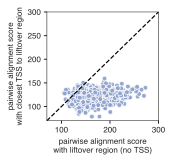

In [52]:
fig = plt.figure(figsize=(2, 2))

ax = sns.scatterplot(data=align, x="orig_align_score", y="closest_align_score", alpha=0.9, 
                     color=sns.color_palette("Set2")[2])
ax.set_xlim((70, 300))
ax.set_ylim((70, 300))
ax.plot([70, 300], [70, 300], linestyle="dashed", color="black")
ax.set_xlabel("pairwise alignment score\nwith liftover region (no TSS)")
ax.set_ylabel("pairwise alignment score\nwith closest TSS to liftover region")
fig.savefig("pairwise_score_scatter.pdf", dpi="figure", bbox_inches="tight")

In [53]:
len(align)

784

In [54]:
len(align[align["orig_align_score"] > align["closest_align_score"]])

762

In [55]:
len(align[align["orig_align_score"] < align["closest_align_score"]])

22

In [56]:
align[align["orig_align_score"] < align["closest_align_score"]]

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,orig_align_score,closest_align_score,orig_align_str,closest_align_str
18,h.2619,m.2431,no CAGE activity,lncRNA,108.4,115.1,AGAAAGGATTCTATTTGTAGAGGAAAAAAATTCTAAAGAGAGGGTA...,AGAAAGGATTCTATTTGTAGAGGAAAAA--A---AT-TC-T--AA-...
68,h.2919,m.2730,no CAGE activity,lncRNA,124.9,129.5,------G-TCTCAA-----GCCTTT----ATTTTTTTA-T---TTT...,--GTCTCAAGCCTTTATTTTTT--TATT---T-TCG-------ATT...
73,h.2961,m.2773,no CAGE activity,mRNA,125.8,133.9,GC--TTGGAGCCCGCGCGAAATCCACCCTTCTG--T-C--CTTGTT...,GC-------T-TGGA-------GCCCGCGC--GAAATCCACCCT--...
137,h.3203,m.3014,no CAGE activity,lncRNA,130.5,134.0,GTCATGCAAGCCATTGTAG---CACAGAGGGAAGAGGCTTTCCGAC...,GTC--ATGCAAGC-CAT-TGTAGCACAGAGGG--AAGAGGCTTTC-...
168,h.3264,m.3074,no CAGE activity,mRNA,127.3,137.9,TCTGCTTCCAAAGAGCAGGC-CAGTT---TCCCCAGCCCCGGGCGA...,TCTGCTTCCAAAGAGCAGG-C-CAGTTTCCC---CAGCCCCGGGCG...
170,h.3268,m.3078,no CAGE activity,mRNA,119.5,125.9,TCGCGCGGGACA--TCGCC-GGG--C--AGC---------------...,---TCGCGCGGGACAT---C--GCCGGGCAGCCCGCACGGCTGGGC...
184,h.3351,m.3161,no CAGE activity,mRNA,116.1,128.4,-TTGCAGG-CGTG---CACCAGCACTGTACATTTGATGTTTGTTTG...,TTGCAGGCGTGCACCAGCACTGTAC-A------T-TTG------AT...
209,h.3422,m.3232,no CAGE activity,eRNA,121.5,126.9,-T-TGCAAAATTCAAGTTAACGATTCATAATGCT-TTTGC---TTC...,-----TT------GCAAAATTCAAGTTAACGATTCATAATGCTTTT...
278,h.3520,m.3330,no CAGE activity,eRNA,138.4,138.5,GAGCC-AGGTGGGCGGGCGG-----GGTCAGTCTGG-----CACTC...,GAGCC--AGGTGGGCGGGCGGGGTCAGT---CTGGCA-CTCA----...
292,h.3540,m.3350,no CAGE activity,eRNA,113.1,135.8,---TCG-AGA---CAC-GGT----------------TTCTCTGTAC...,TCGAGACACGGTTTCTCTGTACAG--CCCTGGCTGTCCTGGAACTC...


In [57]:
align[align["hg19_id"] == "h.1534"]

,hg19_id,mm9_id,minimal_biotype_hg19,minimal_biotype_mm9,orig_align_score,closest_align_score,orig_align_str,closest_align_str
20,h.1534,m.1346,lncRNA,no CAGE activity,160.9,138.5,-----------CTCTC-CTCCCGAAGCTAAGCCACTGCCTTGAGAA...,CTCTC-CTCC--CG--AAGCTAAGCCACTG---------CCT-TGA...


In [59]:
mo_closest[mo_closest["mm9_id"] == "m.1346"]

,chr_tss_mm9,start_tss_mm9,end_tss_mm9,mm9_id,dist,strand_tss_mm9,tss_tile_num,start_tile_mm9,end_tile_mm9
277,chr3,122215928,122215929,m.1346,7616,-,tile1,122215898,122216042


In [60]:
test = "TGTTTTGGGCTATACTGCCCCTGAGGCCCAGGGTCAAAGGCCACTGGGGAACTGCTGTCGTTCCCATCTCCACGTTAGGGCAGTTATAAAAGAGAACAAGGAAGCTCCCACAGGAAGAAAGCCGCCTGGCCTTGTTCCTATGTCT"

In [62]:
hu_seq = non_cons_mo_sub[non_cons_mo_sub["mm9_id"] == "m.1346"]["orig_human_seq"].iloc[0]
hu_seq

'CTCTCCTCCCGAAGCTAAGCCACTGCCTTGAGAAGGAGGGGCTGCAAATGGTCTGAGGCTGCTGGCAGCTGGCCAAGAGTTCAATTACCTGGGCCACAGCCCGCCCTCCTAGTTCTTCCGGTTACTGACTCTGTGGCTGCTGCC'

In [63]:
pairwise2.align.localms(hu_seq, test, 2, -1, -1, -0.1, one_alignment_only=True)

[('-CTCTCCTCCCGAAGCTAAGCCACTGCCT-TGAGAAGG---AGGGGCTGCAAATGG--TCTGAGG--CTGCTG--G----CAGCTGGCCA----AG---AGTT-----------CAATTACCTGG--G---CCACAG-------CCCGCCCT--CCTAGTTCTTCCGGTTACTGACTCTGTGGCTGCTGCC',
  'TGTTT--T---G-GGCTA---TACTGCCCCTG---AGGCCCAGGG--T-CAAA-GGCCACTGGGGAACTGCTGTCGTTCCCATCT--CCACGTTAGGGCAGTTATAAAAGAGAACAA------GGAAGCTCCCACAGGAAGAAAGCCG-CCTGGCCTTGTTC--C----TA-TG--TCT------------',
  133.80000000000018,
  2,
  179)]

In [64]:
neg_test = "AGACATAGGAACAAGGCCAGGCGGCTTTCTTCCTGTGGGAGCTTCCTTGTTCTCTTTTATAACTGCCCTAACGTGGAGATGGGAACGACAGCAGTTCCCCAGTGGCCTTTGACCCTGGGCCTCAGGGGCAGTATAGCCCAAAACA"

In [65]:
pairwise2.align.localms(hu_seq, neg_test, 2, -1, -1, -0.1, one_alignment_only=True)

[('CTCTCCTCCCGAAGCTAAGCCACT-GCCTTGAG-AAGG--AGG-GGCTGCAAATGGTCTGAGG--CTGCTGGCAGCTGGCCAAGA--GTTC--------AA-T----TACC-------TGGG--CCACAGCCCGCCCTCCTAGTTCTTCC----GG--TTACTGACTCTGTGGC-T-----GC----T-GCC-------',
  '------------AG--A---CA-TAG----GAACAAGGCCAGGCGGCT-----T--TCT----TCCTG-TGGGAGCT-TCC----TTGTTCTCTTTTATAACTGCCCTAACGTGGAGATGGGAACGACAGC----------AGTTC--CCCAGTGGCCTT--TGACCCTG-GGCCTCAGGGGCAGTATAGCCCAAAACA',
  125.10000000000014,
  12,
  192)]